In [1]:
import cv2
import numpy as np
from IPython.display import display, Image

In [2]:
# Specify the paths for the model files 
protoFile = "models/colorization_deploy_v2.prototxt"
weightsFile = "models/colorization_release_v2.caffemodel"
#weightsFile = "./models/colorization_release_v2_norebal.caffemodel"; 
# Read the input image
frame = cv2.imread("./img/boat512.png")
W_in = 224
H_in = 224
# Read the network into Memory 
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile) 

In [ ]:
display(Image(filename='./img/boat512.png'))

In [3]:
# Load the bin centers
pts_in_hull = np.load('models/pts_in_hull.npy')
 
# populate cluster centers as 1x1 convolution kernel
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

In [4]:
#Convert the rgb values of the input image to the range of 0 to 1
img_rgb = (frame[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
img_l = img_lab[:,:,0] # pull out L channel

In [5]:
# resize the lightness channel to network input size 
img_l_rs = cv2.resize(img_l, (W_in, H_in)) # resize image to network input size
img_l_rs -= 50 # subtract 50 for mean-centering

In [6]:
net.setInput(cv2.dnn.blobFromImage(img_l_rs))
ab_dec = net.forward()[0,:,:,:].transpose((1,2,0)) # this is our result
 
(H_orig,W_orig) = img_rgb.shape[:2] # original image size
ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR), 0, 1)
 
cv2.imwrite('colorizedbt.png', cv2.resize(img_bgr_out*255,(512,512)))

True

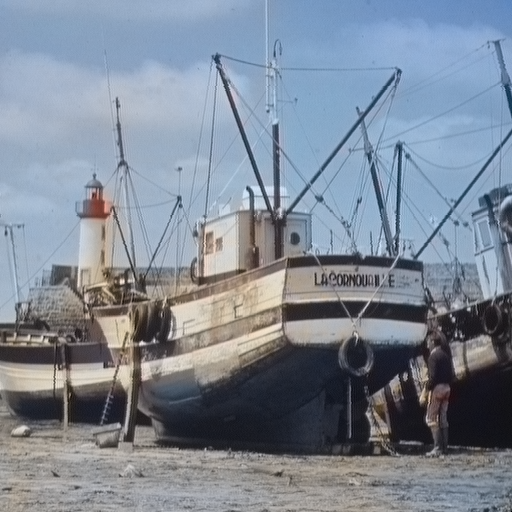

In [9]:
display(Image(filename='colorizedbt.png'))